In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

from nyaggle.experiment import run_experiment

pd.set_option('display.max_columns', 50)

In [22]:
train_df = pd.read_parquet('../data/feature_engineering_v4_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v4_test_df.parquet')

In [23]:
train_label = pd.read_csv('../train_label.csv')
train_log = pd.read_csv('../train_log.csv')
test_session = pd.read_csv('../test_session.csv')
test_log = pd.read_csv('../test_log.csv')

In [7]:
"""
# MultiuHotEncodingはメモリが足りない
from sklearn.preprocessing import MultiLabelBinarizer
# session_idごとにyad_noのリストを作成
session_yadno = train_log.groupby('session_id')['yad_no'].apply(list)
# MultiLabelBinarizerのインスタンスを作成
mlb = MultiLabelBinarizer()
# MultiHotEncodingを実施
multi_hot_encoded = mlb.fit_transform(session_yadno)
# 結果をDataFrameに変換
multi_hot_df = pd.DataFrame(multi_hot_encoded, columns=mlb.classes_, index=session_yadno.index)
# 結果の最初の数行を表示
multi_hot_df.head()
"""

,2,3,4,5,6,7,9,10,11,12,...,13796,13797,13798,13799,13800,13801,13803,13804,13805,13806
session_id,,,,,,,,,,,,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000ca043ed437a1472c9d1d154eb49b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000d4835cf113316fe447e2f80ba1c8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000fcda1ae1b2f431e55a7075d1f500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000104bdffaaad1a1e0a9ebacf585f33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# train_logとtest_logを結合
log_df = pd.concat([train_log, test_log], sort=False)

# session_idごとにyad_noのリストを作成
session_yadno = log_df.groupby('session_id')['yad_no'].apply(list)
# session_yadnoがシリーズであるため、これをデータフレームに変換
session_yadno_df = session_yadno.reset_index(name='yadno_list')
session_yadno_df

,session_id,yadno_list
0,000007603d533d30453cc45d0f3d119f,[2395]
1,00001149e9c73985425197104712478c,"[3560, 1959]"
2,0000ca043ed437a1472c9d1d154eb49b,[13535]
3,0000d4835cf113316fe447e2f80ba1c8,[123]
4,0000e02747d749a52b7736dfa751e258,[11984]
...,...,...
463393,ffff9a7dcc892875c7a8b821fa436228,[8989]
463394,ffffb1d30300fe17f661941fd085b04b,[6030]
463395,ffffcd5bc19d62cad5a3815c87818d83,"[12230, 10619, 12230]"
463396,ffffe984aafd6127ce8e43e3ca40c79d,[8250]


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# yadno_listの各要素を文字列に変換
session_yadno_df['yadno_list_str'] = session_yadno_df['yadno_list'].apply(lambda x: ' '.join(map(str, x)))
# TF-IDFベクトルライザーの初期化
tfidf_vectorizer = TfidfVectorizer()
# yadno_list_str列にTF-IDF適用
tfidf_matrix = tfidf_vectorizer.fit_transform(session_yadno_df['yadno_list_str'])

# SVDの初期化（n次元に圧縮）
svd = TruncatedSVD(n_components=10, random_state=42)
# TF-IDF行列にSVDを適用
svd_matrix = svd.fit_transform(tfidf_matrix)
# 結果をデータフレームに追加
df_svd = pd.DataFrame(svd_matrix, columns=['SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10'])

In [26]:
df_svd

,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,-6.464468e-11,2.891166e-10,-3.660427e-10,-2.273841e-09,4.557487e-10,-4.159502e-09,-3.617492e-09,-1.332808e-08,-4.444905e-09,1.270314e-09
1,-3.463664e-06,-1.040443e-05,1.113840e-05,5.396236e-05,-7.213977e-05,6.641739e-05,1.259168e-06,3.709087e-04,3.118973e-04,-4.967234e-04
2,-5.978436e-08,-1.443403e-07,-7.438706e-07,1.818955e-06,4.992685e-06,3.372739e-06,-1.433128e-05,-2.026924e-05,2.013090e-05,2.943140e-05
3,-7.211434e-10,-4.702856e-10,-5.611851e-09,8.650022e-09,-1.469572e-08,-2.666743e-08,-5.462524e-08,2.190826e-08,-4.270148e-08,-2.773235e-08
4,4.135288e-04,-6.844452e-06,2.621962e-03,2.017062e-04,-2.268762e-04,8.729391e-04,1.513901e-04,-9.936004e-06,-7.057449e-04,-3.924756e-04
...,...,...,...,...,...,...,...,...,...,...
463393,-1.712870e-06,-3.114490e-06,-2.240174e-05,4.503927e-04,5.232237e-04,6.334048e-05,2.631501e-05,-6.399591e-05,-6.301729e-05,-7.216633e-05
463394,-1.193886e-05,-1.372869e-05,-6.676418e-05,5.990706e-05,-1.412355e-04,-1.268508e-04,1.693622e-04,1.087538e-04,8.125785e-05,4.445083e-04
463395,2.983684e-08,1.918854e-06,-4.454749e-07,-1.956481e-05,1.003508e-05,9.055960e-06,8.319465e-05,-7.836168e-05,7.000658e-05,8.072539e-05
463396,1.218516e-05,-2.288626e-06,2.281290e-05,-7.400444e-05,6.028522e-05,1.106125e-04,-8.938183e-04,9.540216e-04,-9.736687e-05,-1.681874e-04


In [27]:
# df_svdをsession_yadno_dfに結合
session_yadno_df = pd.concat([session_yadno_df, df_svd], axis=1)
session_yadno_df

,session_id,yadno_list,yadno_list_str,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,000007603d533d30453cc45d0f3d119f,[2395],2395,-6.464468e-11,2.891166e-10,-3.660427e-10,-2.273841e-09,4.557487e-10,-4.159502e-09,-3.617492e-09,-1.332808e-08,-4.444905e-09,1.270314e-09
1,00001149e9c73985425197104712478c,"[3560, 1959]",3560 1959,-3.463664e-06,-1.040443e-05,1.113840e-05,5.396236e-05,-7.213977e-05,6.641739e-05,1.259168e-06,3.709087e-04,3.118973e-04,-4.967234e-04
2,0000ca043ed437a1472c9d1d154eb49b,[13535],13535,-5.978436e-08,-1.443403e-07,-7.438706e-07,1.818955e-06,4.992685e-06,3.372739e-06,-1.433128e-05,-2.026924e-05,2.013090e-05,2.943140e-05
3,0000d4835cf113316fe447e2f80ba1c8,[123],123,-7.211434e-10,-4.702856e-10,-5.611851e-09,8.650022e-09,-1.469572e-08,-2.666743e-08,-5.462524e-08,2.190826e-08,-4.270148e-08,-2.773235e-08
4,0000e02747d749a52b7736dfa751e258,[11984],11984,4.135288e-04,-6.844452e-06,2.621962e-03,2.017062e-04,-2.268762e-04,8.729391e-04,1.513901e-04,-9.936004e-06,-7.057449e-04,-3.924756e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463393,ffff9a7dcc892875c7a8b821fa436228,[8989],8989,-1.712870e-06,-3.114490e-06,-2.240174e-05,4.503927e-04,5.232237e-04,6.334048e-05,2.631501e-05,-6.399591e-05,-6.301729e-05,-7.216633e-05
463394,ffffb1d30300fe17f661941fd085b04b,[6030],6030,-1.193886e-05,-1.372869e-05,-6.676418e-05,5.990706e-05,-1.412355e-04,-1.268508e-04,1.693622e-04,1.087538e-04,8.125785e-05,4.445083e-04
463395,ffffcd5bc19d62cad5a3815c87818d83,"[12230, 10619, 12230]",12230 10619 12230,2.983684e-08,1.918854e-06,-4.454749e-07,-1.956481e-05,1.003508e-05,9.055960e-06,8.319465e-05,-7.836168e-05,7.000658e-05,8.072539e-05
463396,ffffe984aafd6127ce8e43e3ca40c79d,[8250],8250,1.218516e-05,-2.288626e-06,2.281290e-05,-7.400444e-05,6.028522e-05,1.106125e-04,-8.938183e-04,9.540216e-04,-9.736687e-05,-1.681874e-04


In [28]:
session_yadno_df[session_yadno_df['session_id'] == '000104bdffaaad1a1e0a9ebacf585f33']

,session_id,yadno_list,yadno_list_str,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
7,000104bdffaaad1a1e0a9ebacf585f33,"[96, 898]",96 898,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071


In [29]:
session_yadno_df["SVD1"].value_counts().nunique()  

179

In [30]:
train_df = pd.merge(train_df, session_yadno_df[['session_id', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']], on='session_id', how='left')
test_df = pd.merge(test_df, session_yadno_df[['session_id', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']], on='session_id', how='left')

In [31]:
train_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,...,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,000104bdffaaad1a1e0a9ebacf585f33,96,1,0,1,1,1,0,0,0,228.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,...,35814,14299,14011,626,0,0.060860,0.057156,0.078427,0.072278,0.068568,0.063872,0.066380,0.061979,0.038986,0.037540,-1.794451e-06,-1.047184e-06,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
1,000104bdffaaad1a1e0a9ebacf585f33,902,0,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,...,35814,14299,14011,639,0,0.060860,0.057156,0.078427,0.072278,0.068568,0.063872,0.066380,0.061979,0.067568,0.063124,-1.794451e-06,-1.047184e-06,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
2,000104bdffaaad1a1e0a9ebacf585f33,5490,0,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,...,35814,14299,14011,848,0,0.060860,0.057156,0.078427,0.072278,0.068568,0.063872,0.066380,0.061979,0.053901,0.051068,-1.794451e-06,-1.047184e-06,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
3,000104bdffaaad1a1e0a9ebacf585f33,1284,0,-1,0,1,-1,-1,0,0,176.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,141.0,979.5,128.0,14.0,...,35814,14299,14011,733,0,0.060860,0.057156,0.078427,0.072278,0.068568,0.063872,0.066380,0.061979,0.054187,0.051335,-1.794451e-06,-1.047184e-06,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
4,000104bdffaaad1a1e0a9ebacf585f33,12491,0,-1,0,1,-1,-1,0,0,144.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,179.0,547.5,58.0,5.0,...,35814,14299,14011,830,0,0.060860,0.057156,0.078427,0.072278,0.068568,0.063872,0.066380,0.061979,0.069630,0.064877,-1.794451e-06,-1.047184e-06,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886975,fffe8c99c5b332190c3d4a2d6e7c5073,12544,0,-1,0,1,-1,-1,0,0,122.0,-1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,59.0,3745.0,125.0,14.0,...,11219,10395,8972,292,4,0.072155,0.066949,0.087579,0.079918,0.080724,0.074216,0.076849,0.070953,0.071429,0.066606,-2.870128e-07,2.193063e-07,-0.000001,-0.000007,-0.000004,-0.000028,-0.000020,-0.000042,0.000013,0.000081
2886976,fffe8c99c5b332190c3d4a2d6e7c5073,12005,0,-1,0,1,-1,-1,0,0,128.0,1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,56.0,3941.5,134.0,18.0,...,11219,10395,8972,163,4,0.072155,0.066949,0.087579,0.079918,0.080724,0.074216,0.076849,0.070953,0.055556,0.052889,-2.870128e-07,2.193063e-07,-0.000001,-0.000007,-0.000004,-0.000028,-0.000020,-0.000042,0

In [32]:
test_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,...,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,00001149e9c73985425197104712478c,3560,0,0,1,1,1,0,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,86.0,2418.5,588.0,339.0,...,674516,384957,23029,9672,544.0,0.063105,0.059122,0.055998,0.052863,0.061835,0.058014,0.059967,0.056377,0.049632,0.047256,-0.000003,-0.000010,0.000011,0.000054,-0.000072,0.000066,0.000001,0.000371,0.000312,-0.000497
1,00001149e9c73985425197104712478c,4545,0,-1,0,1,-1,-1,0,0,186.0,-1.0,0,-1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,58.0,3804.5,864.0,505.0,...,674516,384957,23029,9672,392.0,0.063105,0.059122,0.055998,0.052863,0.061835,0.058014,0.059967,0.056377,0.079082,0.073014,-0.000003,-0.000010,0.000011,0.000054,-0.000072,0.000066,0.000001,0.000371,0.000312,-0.000497
2,00001149e9c73985425197104712478c,9534,0,-1,0,1,-1,-1,0,0,136.0,1.0,0,-1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,180.0,536.0,153.0,67.0,...,674516,384957,23029,9672,802.0,0.063105,0.059122,0.055998,0.052863,0.061835,0.058014,0.059967,0.056377,0.056110,0.053028,-0.000003,-0.000010,0.000011,0.000054,-0.000072,0.000066,0.000001,0.000371,0.000312,-0.000497
3,00001149e9c73985425197104712478c,5785,0,-1,0,1,-1,-1,0,0,225.0,1.0,0,1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,82.0,2579.0,618.0,360.0,...,674516,384957,23029,9672,363.0,0.063105,0.059122,0.055998,0.052863,0.061835,0.058014,0.059967,0.056377,0.044077,0.042251,-0.000003,-0.000010,0.000011,0.000054,-0.000072,0.000066,0.000001,0.000371,0.000312,-0.000497
4,00001149e9c73985425197104712478c,6563,0,-1,0,1,-1,-1,0,0,408.0,1.0,0,1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,113.0,1569.5,407.0,218.0,...,674516,384957,23029,9672,413.0,0.063105,0.059122,0.055998,0.052863,0.061835,0.058014,0.059967,0.056377,0.050847,0.048379,-0.000003,-0.000010,0.000011,0.000054,-0.000072,0.000066,0.000001,0.000371,0.000312,-0.000497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746995,ffffe984aafd6127ce8e43e3ca40c79d,5623,0,-1,0,0,-1,-1,0,0,178.0,1.0,0,1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1,74.0,2931.5,690.0,402.0,...,674516,384957,35281,12803,463.0,0.063105,0.059122,0.055998,0.052863,0.063972,0.059881,0.062329,0.058449,0.073434,0.068189,0.000012,-0.000002,0.000023,-0.000074,0.000060,0.000111,-0.000894,0.000954,-0.000097,-0.000168
1746996,ffffe984aafd6127ce8e43e3ca40c79d,11994,0,-1,0,0,-1,-1,0,0,334.0,1.0,0,1.0,-1.0,-1.0,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,372d41b6f39f1f523d0841fd9b84ae44,135.0,1096.5,295.0,147.0,...,674516,384957,35281,5408,549.0,0.063105,0.059122,0.055998,0.052863,0.063972,0.059881,0.067493,0.062949,0.071038,0.066112,0.000012,-0.000002,0.000023,-0.000074,0.000060,0.000111,-0.000894,0.000954,-0.

### LightGBM

In [33]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd')]
target = 'target'  # ターゲット変数の列名


# LightGBM のパラメータ
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

print(features)

['yado_no', 'seq_no', 'seen_yad', 'max_seq_no', 'diff_seq_no', 'is_odd', 'multiple_visits_flag', 'yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min', 'popularity', 'overall_rank', 'wid_cd_rank', 'ken_cd_rank', 'lrg_cd_rank', 'sml_cd_rank', 'label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd', 'count_wid_cd', 'count_ken_cd', 'count_lrg_cd', 'count_sml_cd', 'count_yado_no', 'TE_wid_cd_mean', 'TE_wid_cd_var', 'TE_ken_cd_mean', 'TE_ken_cd_var', 'TE_lrg_cd_mean', 'TE_lrg_cd_var', 'TE_sml_cd_mean', 'TE_sml_cd_var', 'TE_yado_no_mean', 'TE_yado_no_var', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']


In [34]:
print(len(features))

50


In [35]:
train_df[target].isnull().sum()

0

In [36]:
train_df['fold'].value_counts()

0    577400
1    577400
2    577400
3    577390
4    577390
Name: fold, dtype: int64

In [37]:
# 交差検証の実施
auc_scores = [] # 各foldのAUCスコアを保存するリスト
test_pred = [] # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化


for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # LightGBM モデルの初期化
    model = lgb.LGBMClassifier(**params,
                               n_estimators=3000,
                               n_jobs=-1)

    # モデルの訓練
    model.fit(
        train_data[features], train_data[target],
        eval_set=[(valid_data[features], valid_data[target])],
        early_stopping_rounds=50, verbose=1, eval_metric='binary_logloss'
    )

    # バリデーションデータでの予測と評価
    valid_pred = model.predict_proba(valid_data[features])[:, 1]
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # テストデータでの予測
    test_pred.append(model.predict_proba(test_df[features])[:, 1])
    
    # aucの計算
    auc_score = roc_auc_score(valid_data[target], valid_pred)
    auc_scores.append(auc_score)
    print(f'Fold {fold}: AUC = {auc_score}')

# 平均 AUC の計算
print(f'Mean AUC: {sum(auc_scores) / len(auc_scores)}')

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.225443
[2]	valid_0's binary_logloss: 0.215273
[3]	valid_0's binary_logloss: 0.207871
[4]	valid_0's binary_logloss: 0.20205
[5]	valid_0's binary_logloss: 0.197237
[6]	valid_0's binary_logloss: 0.193152
[7]	valid_0's binary_logloss: 0.189605
[8]	valid_0's binary_logloss: 0.186508
[9]	valid_0's binary_logloss: 0.183783
[10]	valid_0's binary_logloss: 0.181331
[11]	valid_0's binary_logloss: 0.17914
[12]	valid_0's binary_logloss: 0.177156
[13]	valid_0's binary_logloss: 0.175363
[14]	valid_0's binary_logloss: 0.173728
[15]	valid_0's binary_logloss: 0.172225
[16]	valid_0's binary_logloss: 0.170861
[17]	valid_0's binary_logloss: 0.169613
[18]	valid_0's binary_logloss: 0.168461
[19]	valid_0's binary_logloss: 0.167391
[20]	valid_0's binary_logloss: 0.166417
[21]	valid_0's binary_logloss: 0.165504
[22]	valid_0's binary_logloss: 0.164666
[23]	valid_0's binary_logloss: 0.163888
[24]	valid_0's binary_logloss: 0.163174
[25]	valid_0's binary_logloss: 0.162501
[26]	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.224224
[2]	valid_0's binary_logloss: 0.214128
[3]	valid_0's binary_logloss: 0.206818
[4]	valid_0's binary_logloss: 0.201076
[5]	valid_0's binary_logloss: 0.196317
[6]	valid_0's binary_logloss: 0.192277
[7]	valid_0's binary_logloss: 0.188786
[8]	valid_0's binary_logloss: 0.185703
[9]	valid_0's binary_logloss: 0.182981
[10]	valid_0's binary_logloss: 0.180568
[11]	valid_0's binary_logloss: 0.178385
[12]	valid_0's binary_logloss: 0.17641
[13]	valid_0's binary_logloss: 0.174644
[14]	valid_0's binary_logloss: 0.17302
[15]	valid_0's binary_logloss: 0.171542
[16]	valid_0's binary_logloss: 0.170188
[17]	valid_0's binary_logloss: 0.168955
[18]	valid_0's binary_logloss: 0.167812
[19]	valid_0's binary_logloss: 0.166753
[20]	valid_0's binary_logloss: 0.165779
[21]	valid_0's binary_logloss: 0.164869
[22]	valid_0's binary_logloss: 0.164034
[23]	valid_0's binary_logloss: 0.16326
[24]	valid_0's binary_logloss: 0.162544
[25]	valid_0's binary_logloss: 0.16188
[26]	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.223863
[2]	valid_0's binary_logloss: 0.213719
[3]	valid_0's binary_logloss: 0.206405
[4]	valid_0's binary_logloss: 0.20062
[5]	valid_0's binary_logloss: 0.195832
[6]	valid_0's binary_logloss: 0.191736
[7]	valid_0's binary_logloss: 0.18822
[8]	valid_0's binary_logloss: 0.185126
[9]	valid_0's binary_logloss: 0.182386
[10]	valid_0's binary_logloss: 0.179928
[11]	valid_0's binary_logloss: 0.177734
[12]	valid_0's binary_logloss: 0.175759
[13]	valid_0's binary_logloss: 0.173971
[14]	valid_0's binary_logloss: 0.172329
[15]	valid_0's binary_logloss: 0.170835
[16]	valid_0's binary_logloss: 0.169469
[17]	valid_0's binary_logloss: 0.168216
[18]	valid_0's binary_logloss: 0.167065
[19]	valid_0's binary_logloss: 0.165994
[20]	valid_0's binary_logloss: 0.164997
[21]	valid_0's binary_logloss: 0.164085
[22]	valid_0's binary_logloss: 0.163237
[23]	valid_0's binary_logloss: 0.162453
[24]	valid_0's binary_logloss: 0.161725
[25]	valid_0's binary_logloss: 0.161054
[26]	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.223358
[2]	valid_0's binary_logloss: 0.213253
[3]	valid_0's binary_logloss: 0.205953
[4]	valid_0's binary_logloss: 0.200188
[5]	valid_0's binary_logloss: 0.195398
[6]	valid_0's binary_logloss: 0.19133
[7]	valid_0's binary_logloss: 0.187785
[8]	valid_0's binary_logloss: 0.184675
[9]	valid_0's binary_logloss: 0.181949
[10]	valid_0's binary_logloss: 0.179496
[11]	valid_0's binary_logloss: 0.177288
[12]	valid_0's binary_logloss: 0.175296
[13]	valid_0's binary_logloss: 0.173485
[14]	valid_0's binary_logloss: 0.171844
[15]	valid_0's binary_logloss: 0.17034
[16]	valid_0's binary_logloss: 0.168976
[17]	valid_0's binary_logloss: 0.16772
[18]	valid_0's binary_logloss: 0.166568
[19]	valid_0's binary_logloss: 0.165495
[20]	valid_0's binary_logloss: 0.164493
[21]	valid_0's binary_logloss: 0.163588
[22]	valid_0's binary_logloss: 0.162739
[23]	valid_0's binary_logloss: 0.161956
[24]	valid_0's binary_logloss: 0.161227
[25]	valid_0's binary_logloss: 0.160549
[26]	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.224619
[2]	valid_0's binary_logloss: 0.214513
[3]	valid_0's binary_logloss: 0.207225
[4]	valid_0's binary_logloss: 0.201438
[5]	valid_0's binary_logloss: 0.196679
[6]	valid_0's binary_logloss: 0.192633
[7]	valid_0's binary_logloss: 0.189143
[8]	valid_0's binary_logloss: 0.186055
[9]	valid_0's binary_logloss: 0.183352
[10]	valid_0's binary_logloss: 0.180918
[11]	valid_0's binary_logloss: 0.178729
[12]	valid_0's binary_logloss: 0.176768
[13]	valid_0's binary_logloss: 0.17498
[14]	valid_0's binary_logloss: 0.173362
[15]	valid_0's binary_logloss: 0.171882
[16]	valid_0's binary_logloss: 0.170529
[17]	valid_0's binary_logloss: 0.169293
[18]	valid_0's binary_logloss: 0.168157
[19]	valid_0's binary_logloss: 0.1671
[20]	valid_0's binary_logloss: 0.166136
[21]	valid_0's binary_logloss: 0.165227
[22]	valid_0's binary_logloss: 0.164399
[23]	valid_0's binary_logloss: 0.163627
[24]	valid_0's binary_logloss: 0.162918
[25]	valid_0's binary_logloss: 0.162263
[26]	valid_0

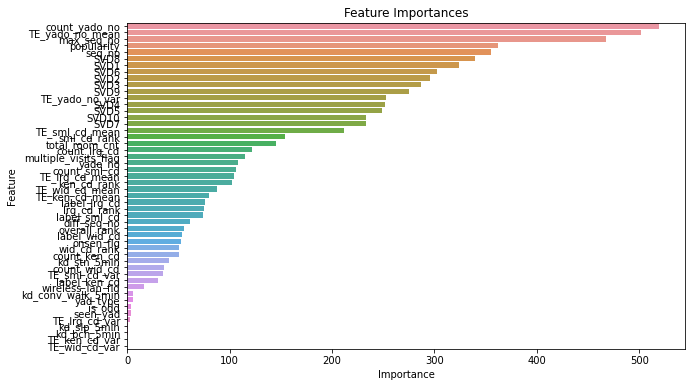

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importances_

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [39]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yado_no', 'oof_pred']].head()

,session_id,yado_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,96,0.842592
1,000104bdffaaad1a1e0a9ebacf585f33,902,0.020351
2,000104bdffaaad1a1e0a9ebacf585f33,5490,0.014760
3,000104bdffaaad1a1e0a9ebacf585f33,1284,0.015467
4,000104bdffaaad1a1e0a9ebacf585f33,12491,0.019959


In [40]:
# Use 'session_id' from train_label to order train_df
train_df_ordered = train_df.set_index('session_id').loc[train_label['session_id']].reset_index()[['session_id', 'yado_no', 'oof_pred']]
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.128340
1,000007603d533d30453cc45d0f3d119f,2808,0.128394
2,000007603d533d30453cc45d0f3d119f,5289,0.140259
3,000007603d533d30453cc45d0f3d119f,4101,0.153566
4,000007603d533d30453cc45d0f3d119f,3324,0.196981


In [18]:
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.013555
1,000007603d533d30453cc45d0f3d119f,2808,0.038119
2,000007603d533d30453cc45d0f3d119f,4101,0.010698
3,000007603d533d30453cc45d0f3d119f,5289,0.011673
4,000007603d533d30453cc45d0f3d119f,9187,0.000309


In [41]:
# train_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = train_df_ordered.sort_values(by=['session_id', 'oof_pred'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
result_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
result_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
result_df = result_df.reset_index()

result_df.head()



,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,3324,4101,5289,2808,11882,9187,9180,9178,9179,9177
1,0000ca043ed437a1472c9d1d154eb49b,1092,8747,3725,4488,2259,9881,2570,1586,8253,11104
2,0000d4835cf113316fe447e2f80ba1c8,4863,7509,4355,13642,9039,6722,1967,11724,5238,9158
3,0000fcda1ae1b2f431e55a7075d1f500,13549,626,2272,755,109,11715,13296,7872,121,7812
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,902,12491,7749,1284,12338,5490,11380,7599


In [20]:
# result_df.to_csv('../data/lgbBinary_ver3_result_df.csv', index=False)

In [42]:
train_label

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,2259
288694,ffff2360540745117193ecadcdc06538,963
288695,ffff7fb4617164b2604aaf51c40bf82d,13719
288696,ffffcd5bc19d62cad5a3815c87818d83,10619


In [43]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.drop(columns=['session_id']).values

In [44]:
y_true

array([[ 4101],
       [ 8253],
       [ 4863],
       ...,
       [13719],
       [10619],
       [ 2439]])

In [45]:
y_pred

array([[ 3324,  4101,  5289, ...,  9178,  9179,  9177],
       [ 1092,  8747,  3725, ...,  1586,  8253, 11104],
       [ 4863,  7509,  4355, ..., 11724,  5238,  9158],
       ...,
       [10364,  2087, 12240, ...,  7820,  4040,   844],
       [10619,   570, 12500, ..., 12781, 10616,  1820],
       [ 2439, 10095,   846, ...,  5800,  2981, 12154]])

In [46]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [48]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')


Map@10  0.4242050777618221


### 予測ファイルの作成

In [ ]:
#　testデータに結合
#　session_idとyado_noとtargetを結合
#  session_idごとにtargetの上位10件のyado_noを抽出を抽出し、画像のような横10列のデータセットに整形してください

In [49]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[0.92148233 0.0134372  0.0157475  ... 0.02590581 0.02268184 0.02613912]
1747000


In [50]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yado_no', 'target']].head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.921482
1,00001149e9c73985425197104712478c,4545,0.013437
2,00001149e9c73985425197104712478c,9534,0.015747
3,00001149e9c73985425197104712478c,5785,0.007545
4,00001149e9c73985425197104712478c,6563,0.009909


In [51]:
test_session

,session_id
0,00001149e9c73985425197104712478c
1,0000e02747d749a52b7736dfa751e258
2,0000f17ae2628237d78d3a38b009d3be
3,000174a6f7a569b84c5575760d2e9664
4,00017e2a527901c9c41b1acef525d016
...,...
174695,fffee3199ef94b92283239cd5e3534fa
174696,ffff62c6bb49bc9c0fbcf08494a4869c
174697,ffff9a7dcc892875c7a8b821fa436228
174698,ffffb1d30300fe17f661941fd085b04b


In [52]:
# Use 'session_id' from test_session to order test_df
test_df_ordered = test_df.set_index('session_id').loc[test_session['session_id']].reset_index()[['session_id', 'yado_no', 'target']]
test_df_ordered.head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.921482
1,00001149e9c73985425197104712478c,4545,0.013437
2,00001149e9c73985425197104712478c,9534,0.015747
3,00001149e9c73985425197104712478c,5785,0.007545
4,00001149e9c73985425197104712478c,6563,0.009909


In [53]:
test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.921482
7,00001149e9c73985425197104712478c,11561,0.019199
9,00001149e9c73985425197104712478c,2680,0.017648
2,00001149e9c73985425197104712478c,9534,0.015747
8,00001149e9c73985425197104712478c,5466,0.014680
...,...,...,...
1746997,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.025906
1746993,ffffe984aafd6127ce8e43e3ca40c79d,867,0.024511
1746991,ffffe984aafd6127ce8e43e3ca40c79d,10729,0.024235
1746995,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.022685


In [54]:
# test_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
submit_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
submit_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
submit_df = submit_df.reset_index()

submit_df.head()

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,11561,2680,9534,5466,4545,4420,4714,6563,5785
1,0000e02747d749a52b7736dfa751e258,8108,4066,613,143,6129,11237,7014,6555,7913,12862
2,0000f17ae2628237d78d3a38b009d3be,757,9910,410,1774,7710,9190,6721,10485,10104,3400
3,000174a6f7a569b84c5575760d2e9664,12341,6991,3359,10861,6489,4180,10746,5080,1542,13521
4,00017e2a527901c9c41b1acef525d016,3476,9623,2862,9020,10826,5372,12029,3854,6161,3844


In [55]:
# 欠損がないかをチェック
print(submit_df.isnull().sum(axis=1).sum())
print(submit_df.shape)

0
(174700, 11)


In [34]:
# submit_df.to_csv('../data/lgbBinary_ver3_submit_df.csv', index=False)

In [56]:
submit_df.drop(columns=['session_id']).to_csv('../submissions/lgbBinary_ver6.csv', index=False)